
# Cart-based Recommendation System

This notebook is designed for your `cart` export CSV (extracted from your database). It builds a co-occurrence recommender:
1. **Co-occurrence-based** (people who added X also added Y) — great for "items in current cart → what else to recommend".

**Assumptions & notes**
- Input CSV should contain at least: `cart_session`, `cart_product_id`, `cart_quantity` (quantity optional). Each row is a cart line item.
- We'll treat interactions as implicit signals (presence = 1). Quantities are ignored by default.


In [2]:

# Standard imports
import math, os, json, pickle
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

# Display options
pd.set_option("display.max_columns", 200)


In [3]:
# === 1) Load your CSV ===
# Replace the filename below with the path to your CSV exported from your database.
# Expected columns: cart_session, cart_product_id, cart_quantity (optional), cart_product_desc (optional)

CSV_PATH = "cart_export_11-15.csv"  # <<--- change this to your file path
EVAL_CSV = "answer_2016-01.csv"

In [5]:
print("Loading :", CSV_PATH)
df = pd.read_csv(CSV_PATH, dtype={"cart_session": str, "cart_product_id": object})
print("Rows:", len(df))
df.head()

# filter df by year = 2015
# filter df for year 2018 or 2019

# df = df[df['year'].isin([2018, 2019])]
# print("Rows:", len(df))
# df.head()

Loading : cart_export_11-15.csv
Rows: 10348


,cart_session,cart_product_id,cart_quantity,cart_id,year,month
0,66c5afe9dcbabd09886d04bf4898a18c2c51ecd3,1,1,10014,2011,2
1,ec76f4bd1a933cc998dba373d239cec57b7c99ab,1,1,10016,2011,2
2,ec76f4bd1a933cc998dba373d239cec57b7c99ab,30,1,10017,2011,2
3,ec76f4bd1a933cc998dba373d239cec57b7c99ab,31,1,10018,2011,2
4,661af074bb69a5f5fac2b50edb9b862204e14cfd,4,1,10020,2011,2


Unique sessions: 2175
Unique products: 253
count    2175.000000
mean        4.757701
std         3.800408
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        29.000000
Name: line_items, dtype: float64


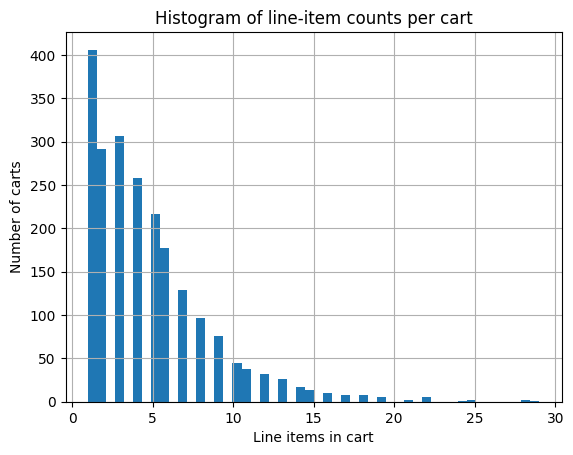

In [6]:

# === 2) Basic EDA ===
print("Unique sessions:", df['cart_session'].nunique())
print("Unique products:", df['cart_product_id'].nunique())

# Quick distribution of items per cart (line-item counts)
items_per_cart = df.groupby('cart_session').size().rename("line_items")
print(items_per_cart.describe())

# Histogram (line items)
items_per_cart.hist(bins=50)
plt.xlabel("Line items in cart")
plt.ylabel("Number of carts")
plt.title("Histogram of line-item counts per cart")
plt.show()


In [7]:
# === 3) Preprocessing ===
df = df.dropna(subset=['cart_session', 'cart_product_id']).copy()
df['cart_product_id'] = df['cart_product_id'].astype(str)

# Preserve product order of first appearance
product_ids = df['cart_product_id'].unique()
product_to_idx = {p: i for i, p in enumerate(product_ids)}
idx_to_product = {i: p for p, i in product_to_idx.items()}

# Preserve session order of first appearance (file order)
sessions = df['cart_session'].unique()
session_to_idx = {s: i for i, s in enumerate(sessions)}
idx_to_session = {i: s for s, i in session_to_idx.items()}

# IMPORTANT: sort=False preserves file order
transactions = (
    df
    .groupby('cart_session', sort=False)['cart_product_id']
    .apply(list)
    .to_dict()
)

# Convert products to indices
transactions = {
    session: [product_to_idx[p] for p in products]
    for session, products in transactions.items()
}

num_sessions = len(session_to_idx)
num_products = len(product_to_idx)

print("Sessions:", num_sessions, "Products:", num_products)


Sessions: 2175 Products: 253


In [8]:
# print a transaction as product ids
first_items = list(transactions.items())[1]
print(first_items)
# print first_items after converting them back to product_ids
first_items = [idx_to_product[i] for i in first_items[1]]
print("First transaction:", first_items)

('ec76f4bd1a933cc998dba373d239cec57b7c99ab', [0, 1, 2])
First transaction: ['1', '30', '31']


In [9]:

# === 4) Build sparse user-item matrix (binary presence) ===
rows = []
cols = []
data = []
for s, products in transactions.items():
    s_idx = session_to_idx[s]
    unique_products = set(products)
    for p_idx in unique_products:
        rows.append(s_idx)
        cols.append(p_idx)
        data.append(1)   # binary interaction

user_item = csr_matrix((data, (rows, cols)), shape=(num_sessions, num_products), dtype=np.float32)
print("User-item matrix shape:", user_item.shape, "nnz:", user_item.nnz)

User-item matrix shape: (2175, 253) nnz: 10283


In [12]:

# show user_item example
print("User-item matrix row 1:")
print(user_item.getrow(1).toarray())

User-item matrix row 1:
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [13]:
#print the first 5 items from product_to_idx
print(list(product_to_idx.items())[:5])
# product_to_idx

[('1', 0), ('30', 1), ('31', 2), ('4', 3), ('36', 4)]


In [14]:

# === 5) Co-occurrence recommender ===
# We'll compute item co-occurrence counts and conditional probability P(j | i) ~ count(i,j) / count(i)

# Compute item counts (in how many sessions each item appears)
item_counts = np.array((user_item > 0).sum(axis=0)).ravel()  # shape (num_products,)
item_counts_dict = dict(enumerate(item_counts))

# Compute co-occurrence: item-item matrix = item_user.T dot item_user (but user_item is session x item)
cooccurrence = (user_item.T).dot(user_item)  # shape (num_products, num_products) as a sparse matrix
# cooccurrence[i,j] = number of sessions containing both i and j

def recommend_by_cooccurrence(items, top_n=10, exclude_existing=True):
    if isinstance(items, (str, int)):
        items = [items]
    scores = defaultdict(float)
    for i in items:
        i = int(i)
        # get cooccurrence row for i
        row = cooccurrence.getrow(i).toarray().ravel()
        # conditional probability P(j|i) = cooccurrence[i,j] / count(i)
        denom = item_counts_dict.get(i, 1)
        probs = row / float(denom) if denom > 0 else row
        for j, p in enumerate(probs):
            scores[j] += p
    # Exclude items already in cart
    if exclude_existing:
        for it in items:
            scores.pop(it, None)
    # Return top_n sorted by score
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return [(idx_to_product[i], float(score)) for i, score in ranked]



In [15]:

# === 8) Popularity fallback & helpers ===
# Top popular items by number of sessions containing them
popular_idx = np.argsort(-item_counts)  # indices sorted by popularity

def recommend_popular(top_n=10, exclude=[]):
    res = []
    for i in popular_idx:
        pid = idx_to_product[i]
        if pid in exclude:
            continue
        res.append((pid, int(item_counts[i])))
        if len(res) >= top_n:
            break
    return res

# Helper: convert product ids to indices (safe)
def product_ids_to_indices(product_ids_list):
    return [product_to_idx[str(p)] for p in product_ids_list if str(p) in product_to_idx]

# Combined interface
def recommend_for_current_cart(product_ids_in_cart, method='cooccurrence', top_n=10):
    indices = product_ids_to_indices(product_ids_in_cart)
    if not indices:
        return recommend_popular(top_n=top_n, exclude=product_ids_in_cart)
    if method == 'cooccurrence':
        return recommend_by_cooccurrence(indices, top_n=top_n)
    if method == 'popular':
        return recommend_popular(top_n=top_n, exclude=product_ids_in_cart)
    raise ValueError("Unknown method")


In [ ]:

# === 9) Example usage ===
# Replace these example product ids with ones from your data
example_cart = [list(product_to_idx.keys())[3]]  # single product example (raw id)
print("Example cart (raw ids):", example_cart)

print("\nCo-occurrence recommendations:")
print(recommend_for_current_cart(example_cart, method='cooccurrence', top_n=10))

# === Optional: save mappings and model artifacts ===
ARTIFACT_DIR = 'recommender_artifacts'
os.makedirs(ARTIFACT_DIR, exist_ok=True)
with open(os.path.join(ARTIFACT_DIR, 'mappings.pkl'), 'wb') as f:
    pickle.dump({'product_to_idx': product_to_idx, 'idx_to_product': idx_to_product,
                 'session_to_idx': session_to_idx, 'idx_to_session': idx_to_session}, f)
print('Saved artifacts to', ARTIFACT_DIR)


Example cart (raw ids): ['4']

Co-occurrence recommendations:
[('3', 0.21556885540485382), ('78', 0.1796407252550125), ('111', 0.1796407252550125), ('15', 0.17365269362926483), ('14', 0.17365269362926483), ('75', 0.16167664527893066), ('6', 0.1497005969285965), ('134', 0.1497005969285965), ('1', 0.13772454857826233), ('12', 0.13772454857826233)]
Saved artifacts to recommender_artifacts


In [17]:
example_cart = [1,30]
print("Example cart (raw ids):", example_cart)

print("\nCo-occurrence recommendations:")
print(recommend_for_current_cart(example_cart, method='cooccurrence', top_n=10))



Example cart (raw ids): [1, 30]

Co-occurrence recommendations:
[('111', 0.38122883439064026), ('12', 0.3369618058204651), ('78', 0.33575230836868286), ('0', 0.3243831694126129), ('4', 0.31132078170776367), ('6', 0.28543782234191895), ('72', 0.27987420558929443), ('62', 0.26632800698280334), ('75', 0.2660861313343048), ('14', 0.2602806091308594)]


In [ ]:
import ast

# === 1) Load evaluation data ===


eval_df = pd.read_csv(
    EVAL_CSV,
    dtype={
        "sale_id": str,
        "prefix_length": int,
        "previous_products": str,
        "answer_product_ids": str
    }
)

print("Evaluation rows:", len(eval_df))

# Parse strings like '[260,4,323]' into lists
eval_df['previous_products']     = eval_df['previous_products'].apply(lambda x: [str(i) for i in ast.literal_eval(x)])
eval_df['answer_product_ids']    = eval_df['answer_product_ids'].apply(lambda x: [str(i) for i in ast.literal_eval(x)])
# === 2) Hit rate@k function ===
def hit_rate_at_k_any(df, method='cooccurrence', k=10):
    hits = 0
    total = len(df)

    for _, row in df.iterrows():
        cart = row['previous_products']
        answers = row['answer_product_ids']

        recs = recommend_for_current_cart(cart, method=method, top_n=k)
        rec_ids = [r[0] for r in recs]

        # any match counts as a hit
        if any(a in rec_ids for a in answers):
            hits += 1

    return hits / total if total > 0 else 0

# === 3) Evaluate each recommender ===
methods = ['cooccurrence']
for m in methods:
    hr = hit_rate_at_k_any(eval_df, method=m, k=10)
    print(f"Hit rate@10 for {m}: {hr:.4f}")



# hr5 = hit_rate_at_k_any(predictions, actuals, 5)
# hr10 = hit_rate_at_k_any(predictions, actuals, 10)

# print("HitRate@5:", hr5)
# print("HitRate@10:", hr10)

Evaluation rows: 281
Hit rate@10 for cooccurrence: 0.4021


In [ ]:
from collections import defaultdict
import numpy as np

# === Hybrid recommender ===
# Weights for each method
WEIGHTS = {
    'cooccurrence': 1
}
def recommend_hybrid(product_ids_in_cart, top_n=10, exclude_existing=True, weights=WEIGHTS):
    indices = product_ids_to_indices(product_ids_in_cart)
    if not indices:
        return recommend_popular(top_n=top_n, exclude=product_ids_in_cart)

    scores = defaultdict(float)

    # Co-occurrence
    co_scores = recommend_by_cooccurrence(indices, top_n=len(product_to_idx), exclude_existing=False)
    for pid, score in co_scores:
        scores[pid] += weights.get('cooccurrence', 0) * score

    # Exclude items already in cart
    if exclude_existing:
        for pid in product_ids_in_cart:
            scores.pop(str(pid), None)

    # Return top_n sorted by combined score
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return [(pid, float(score)) for pid, score in ranked]


def hit_rate_hybrid_at_k(df, method='cooccurrence', k=10):
    hits = 0
    total = len(df)

    for _, row in df.iterrows():
        cart = row['previous_products']
        answers = row['answer_product_ids']

        recs = recommend_hybrid(cart, top_n=k)
        rec_ids = [r[0] for r in recs]

        # any match counts as a hit
        if any(a in rec_ids for a in answers):
            hits += 1

    return hits / total if total > 0 else 0

# === Test hybrid recommender on multiple ks ===
ks = [5, 10, 20]
for k in ks:
    hr = hit_rate_hybrid_at_k(eval_df, k=k)
    print(f"Hybrid HitRate@{k} : {hr:.4f}")


Hybrid HitRate@5 : 0.2491
Hybrid HitRate@10 : 0.4021
Hybrid HitRate@20 : 0.5801


In [49]:
example_cart = [240,200,277,78]
print("Example cart (raw ids):", example_cart)

print("\nHybrid recommendations:")
print(recommend_hybrid(example_cart, top_n=20))

# answers 75,4,130


Example cart (raw ids): [240, 200, 277, 78]

Hybrid recommendations:
[('75', 0.8083494305610657), ('72', 0.5306828618049622), ('227', 0.4915010631084442), ('127', 0.47629988193511963), ('111', 0.46259111166000366), ('172', 0.451528400182724), ('62', 0.4430629014968872), ('0', 0.4389498233795166), ('1', 0.4367251694202423), ('12', 0.4209652245044708), ('14', 0.40798723697662354), ('206', 0.3971453905105591), ('144', 0.3952336311340332), ('15', 0.3661046624183655), ('134', 0.35362884402275085), ('80', 0.3510855436325073), ('123', 0.34115463495254517), ('4', 0.33692997694015503), ('130', 0.32722339034080505), ('173', 0.3248697817325592)]
